In [1]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.3 MB/s eta 0:00:00


In [2]:
!pip install pynvml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.4 MB/s eta 0:00:00


In [3]:
import subprocess

def get_free_gpu():
    """
    Get the ID of a free GPU.
    """
    # Run nvidia-smi to get GPU usage info
    result = subprocess.run(['nvidia-smi', '-q', '-d', 'MEMORY'], stdout=subprocess.PIPE)

    # Decode the output and split it into lines
    output = result.stdout.decode('utf-8')
    lines = output.split('\n')

    # Loop over the lines to find a free GPU
    for i, line in enumerate(lines):
        if 'Free' in line:
          # Extract the GPU ID from the previous line
          gpu_id = lines[i-3]
          return gpu_id

    # If no free GPU was found, return None
    return None

In [4]:
print(get_free_gpu())

        Total                             : 15360 MiB


In [5]:
!python --version

Python 3.10.12


In [6]:
!nvidia-smi

Thu Jun 22 13:15:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
import torch
import base64
from PIL import Image
from io import BytesIO
from tqdm.auto import tqdm
from torch import autocast
from diffusers import LMSDiscreteScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

In [8]:
model_loc = "model/"
# 1. Load the autoencoder model which will be used to decode the latents into image space.
AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").save_pretrained(model_loc + "stable-diffusion-v1-4/VAE/")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14").save_pretrained(model_loc + "clip-vit-large-patch14/")
CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").save_pretrained(model_loc + "clip-vit-large-patch14/")

# 3. The UNet model for generating the latents.
UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").save_pretrained(model_loc + "stable-diffusion-v1-4/")
LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler").save_pretrained(model_loc + "stable-diffusion-v1-4/")

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.14.self_attn.q_proj.bias', 'vision_model.encoder.layers.15.self_attn.v_proj.weight', 'vision_model.encoder.layers.3.mlp.fc1.bias', 'vision_model.encoder.layers.10.mlp.fc2.weight', 'vision_model.encoder.layers.5.self_attn.v_proj.bias', 'vision_model.encoder.layers.4.self_attn.q_proj.bias', 'vision_model.encoder.layers.22.layer_norm2.weight', 'vision_model.encoder.layers.17.self_attn.k_proj.weight', 'vision_model.encoder.layers.1.self_attn.out_proj.bias', 'vision_model.encoder.layers.2.mlp.fc1.weight', 'vision_model.encoder.layers.15.layer_norm2.bias', 'vision_model.encoder.layers.18.mlp.fc1.bias', 'vision_model.encoder.layers.2.mlp.fc1.bias', 'vision_model.encoder.layers.14.layer_norm2.weight', 'vision_model.encoder.layers.1.self_attn.v_proj.weight', 'vision_model.encoder.layers.12.self_attn.q_proj.weight', 'vision_model.encoder.layers.9.laye

In [9]:
class StableDiffusion:

  def __init__(self, model_loc="model/"):

    self.torch_device = "cuda" if torch.cuda.is_available() else "cpu"

    # 1. Load the autoencoder model which will be used to decode the latents into image space.
    self.vae = AutoencoderKL.from_pretrained(model_loc + "stable-diffusion-v1-4/VAE/", subfolder="vae")

    # 2. Load the tokenizer and text encoder to tokenize and encode the text.
    self.tokenizer = CLIPTokenizer.from_pretrained(model_loc + "clip-vit-large-patch14/")
    self.text_encoder = CLIPTextModel.from_pretrained(model_loc + "clip-vit-large-patch14/")

    # 3. The UNet model for generating the latents.
    self.unet = UNet2DConditionModel.from_pretrained(model_loc + "stable-diffusion-v1-4/", subfolder="unet")

    # 4. Using K-LMS scheduler
    self.scheduler = LMSDiscreteScheduler.from_pretrained(model_loc + "stable-diffusion-v1-4/", subfolder="scheduler")

    self.vae = self.vae.to(self.torch_device)
    self.text_encoder = self.text_encoder.to(self.torch_device)
    self.unet = self.unet.to(self.torch_device)

  def generateImage(
      self,
      prompt = "a photograph of an astronaut riding a horse",
      height = 512,
      width = 512,
      num_inference_steps = 50,
      guidance_scale = 7.5,
      seed=32,
      batch_size = 1):

    prompt = [prompt]
    generator = torch.manual_seed(seed)

    #Generating the text Embeddings for the prompt
    text_input = self.tokenizer(prompt,
                                padding="max_length",
                                max_length=self.tokenizer.model_max_length,
                                truncation=True,
                                return_tensors="pt")
    with torch.no_grad():
      text_embeddings = self.text_encoder(
          text_input.input_ids.to(self.torch_device)
          )[0]

    #Generating unconditional text embeddings for classifier-free guidance, which are just the embeddings for the padding token
    max_length = text_input.input_ids.shape[-1]
    uncond_input = self.tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length,
        return_tensors="pt"
        )

    with torch.no_grad():
      uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.torch_device))[0]

    #For classifier-free guidance, we need to do two forward passes. One with the conditioned input (text_embeddings), and another with the unconditional embeddings (uncond_embeddings).
    #In practice, we can concatenate both into a single batch to avoid doing two forward passes.
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    #intial random noise.
    latents = torch.randn(
        (batch_size, self.unet.in_channels, height // 8, width // 8),
        generator=generator,
        )
    latents = latents.to(self.torch_device)

    #initialize the scheduler with our chosen num_inference_steps.
    self.scheduler.set_timesteps(num_inference_steps)

    latents = latents * self.scheduler.init_noise_sigma

    for t in tqdm(self.scheduler.timesteps):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)

      latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = self.scheduler.step(noise_pred, t, latents).prev_sample

    #using the vae to decode the generated latents back into the image.
    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents

    with torch.no_grad():
      image = self.vae.decode(latents).sample

    #convert the image to PIL so we can display or save it.
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]

    im_file = BytesIO()
    pil_images[0].save(im_file, format="JPEG")

    return base64.b64encode(im_file.getvalue())

  def generateMultiple(self, promptArray):
    return {i:self.generateImage(i) for i in promptArray}

In [10]:
sd = StableDiffusion("model/")

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


In [11]:
sd.generateImage()

  0%|          | 0/50 [00:00<?, ?it/s]

b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAIAAgADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDm8UuKeFpcVtc67DMUuKdilxRcLDMUuKfijFK47DMUuKdilouFhuKMU7FLii4DcUYp+KMUXAbijFPxRilcBuKXFOxS7aLgNxSgU7FLSuOw0LS4p1GKLhYTFLilopXGJilxS4pcUXAbilxTgKcBSuOwwCnbacBTgKVwsMApwW

In [12]:
result = sd.generateMultiple(["a photograph of an astronaut riding a horse",
                              "a photograph of shark under the ocean",
                              "Picture of an apple pie",
                              "moon with a face"
                              ])

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [13]:
type(result["a photograph of an astronaut riding a horse"])

bytes

In [14]:
result["a photograph of shark under the ocean"]

b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAIAAgADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwCmp49D70/tjqajHJG79acPTnGOc1sIf24PNKDzgdcUwHvnJpeM/lQA4ZANODcZHSm7s5z/ACpcjA/UUDHcnuMClDY5x7c00E49DRnJAz0pAP3H1zinA9fXFR5IGPancbs8UALk4zTu3WmbucijIHNDGiQHntS56Cmbh7Uu7H

## Base64 to PIL Image

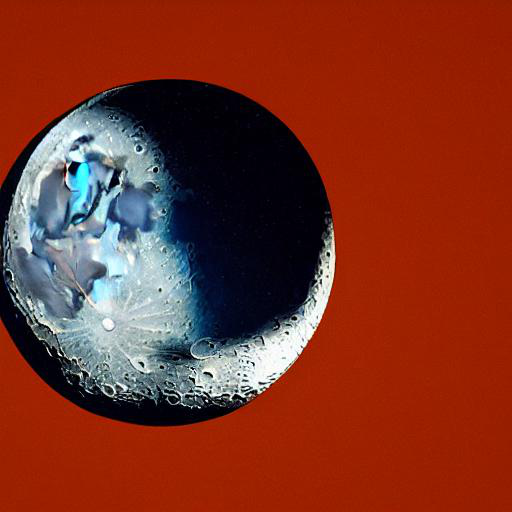

In [17]:
im_bytes = base64.b64decode(result["moon with a face"])   # im_bytes is a binary image
im_file = BytesIO(im_bytes)  # convert image to file-like object
img = Image.open(im_file)
img

In [ ]:
!python --version

Python 3.8.10


In [ ]:
pip freeze > requirements.txt

In [ ]:
!uvicorn  & npx localtunnel --port 8501